<a href="https://colab.research.google.com/github/Igorwtfk/Trabalho-Final-Sistemas-Inteligentes/blob/main/FakeNews_NaiveBayes_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Configuração e Importação de Bibliotecas
Nesta etapa, importamos todas as ferramentas necessárias para o projeto.
Utilizaremos:
* **Pandas e Numpy:** Para manipulação de dados matemáticos e tabelas.
* **Seaborn e Matplotlib:** Para geração de gráficos e visualização de dados.
* **NLTK (Natural Language Toolkit):** Para processamento de linguagem natural (remoção de stopwords, stemming).
* **Scikit-Learn:** Para algoritmos de Machine Learning (Naive Bayes), vetorização (TF-IDF) e métricas de avaliação.

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Bibliotecas de NLP
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Bibliotecas de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer # Adicionado para Bigramas
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Configuração de estilo dos gráficos
sns.set_style("whitegrid")

# Baixando recursos de texto
nltk.download('stopwords')

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 2. Carregamento e Preparação do Dataset
O dataset utilizado é o **ISOT Fake News Dataset**, que contém milhares de artigos de notícias marcadas como "Reais" ou "Falsas".
Aqui, realizamos o download automático via API do Kaggle, carregamos os arquivos CSV e criamos a coluna `target` (alvo), onde:
* **0** = Notícia Real
* **1** = Notícia Falsa (Fake News)

Ao final, combinamos os dados em um único DataFrame e misturamos (embaralhamos) as linhas para garantir aleatoriedade no treino.

In [2]:
# 1. Download do dataset
path = kagglehub.dataset_download("csmalarkodi/isot-fake-news-dataset")

# 2. Leitura dos Arquivos
try:
    df_true = pd.read_csv(os.path.join(path, 'True.csv'))
    df_fake = pd.read_csv(os.path.join(path, 'Fake.csv'))
except FileNotFoundError:
    df_true = pd.read_csv(os.path.join(path, 'true.csv'))
    df_fake = pd.read_csv(os.path.join(path, 'fake.csv'))

# 3. Criação dos Rótulos (Target)
df_fake['target'] = 1
df_true['target'] = 0

# 4. Concatenação e Shuffle (Mistura)
df = pd.concat([df_fake, df_true], axis=0)
df = df.sample(frac=1).reset_index(drop=True)

# 5. Seleção de Dados
# Usaremos Título + Texto para ter mais informação semântica
df['conteudo'] = df['title'] + " " + df['text']
df = df.drop(['title', 'text', 'subject', 'date'], axis=1)

print(f"Total de registros carregados: {df.shape[0]}")
print(df.head())

Using Colab cache for faster access to the 'isot-fake-news-dataset' dataset.
Total de registros carregados: 44898
   target                                           conteudo
0       1   WATCH: Fox News’ Tucker Carlson SCREAMS About...
1       0  Anti-corruption blogger killed by huge bomb in...
2       0  Trump golf club must pay $5.77 million to form...
3       1   GOP Senator Loses His Sh*t On Twitter Over Tr...
4       1  HUGE Spending Agreement Reached: GOP Caves On ...


# 3. Análise Exploratória: Densidade do Texto
Antes de processar o texto, é importante entender as características físicas das notícias.
Existe diferença no tamanho das notícias falsas e verdadeiras?
O gráfico abaixo compara a distribuição da contagem de palavras entre as duas classes.

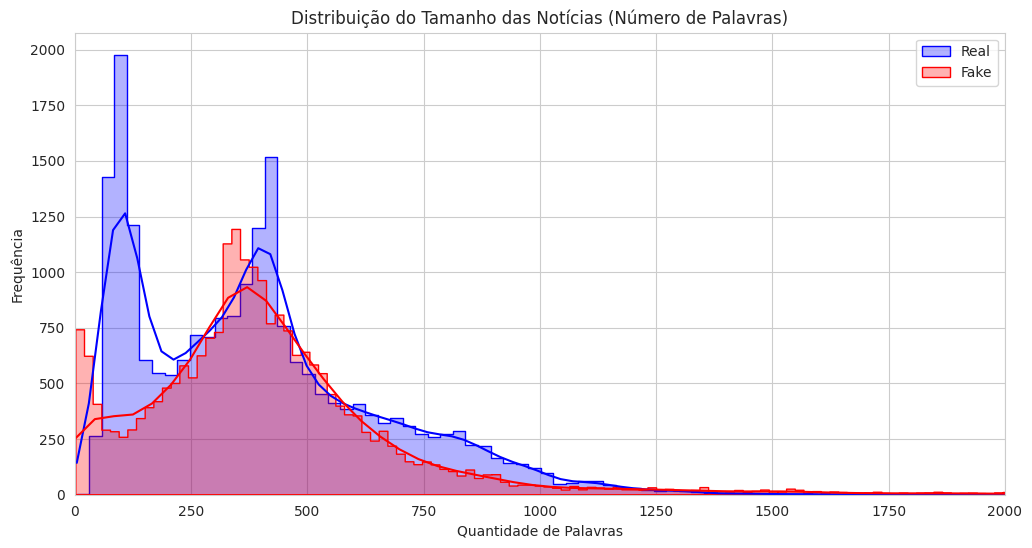

Média de palavras (Real): 395.5945744035112
Média de palavras (Fake): 437.9307099356927


In [3]:
# Criar coluna auxiliar com contagem de palavras
df['num_palavras'] = df['conteudo'].apply(lambda x: len(str(x).split()))

# Plotando o Histograma Comparativo
plt.figure(figsize=(12, 6))
sns.histplot(df[df['target']==0]['num_palavras'], color='blue', label='Real', kde=True, element="step", alpha=0.3)
sns.histplot(df[df['target']==1]['num_palavras'], color='red', label='Fake', kde=True, element="step", alpha=0.3)

plt.title('Distribuição do Tamanho das Notícias (Número de Palavras)')
plt.xlabel('Quantidade de Palavras')
plt.ylabel('Frequência')
plt.xlim(0, 2000) # Focando na maioria dos dados
plt.legend()
plt.show()

print("Média de palavras (Real):", df[df['target']==0]['num_palavras'].mean())
print("Média de palavras (Fake):", df[df['target']==1]['num_palavras'].mean())

# 4. Pré-processamento de Texto (Limpeza)
Para que o algoritmo Naive Bayes funcione bem, precisamos limpar o "ruído" do texto.
A função abaixo aplica as seguintes transformações:
1. **Remoção de caracteres não alfabéticos:** Mantém apenas letras.
2. **Lowercasing:** Transforma tudo para minúsculo.
3. **Remoção de Stopwords:** Remove palavras comuns sem valor semântico (ex: "the", "is", "at").
4. **Stemming:** Reduz as palavras à sua raiz (ex: "running" -> "run").

In [4]:
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def limpar_texto(texto):
    # Remove não-letras
    texto = re.sub('[^a-zA-Z]', ' ', texto)
    # Minusculas
    texto = texto.lower()
    # Tokenização (dividir em lista)
    texto = texto.split()
    # Stemming e Stopwords
    texto = [ps.stem(word) for word in texto if not word in stop_words]
    return ' '.join(texto)

# Aplicando a função em todo o dataset
df['conteudo_limpo'] = df['conteudo'].apply(limpar_texto)

# 5. Análise de Bigramas (Pares de Palavras)
Além de palavras isoladas, analisamos pares de palavras (Bigramas) para capturar contexto.
O gráfico abaixo mostra os termos compostos mais frequentes nas notícias falsas, o que ajuda a identificar narrativas recorrentes (ex: "White House", "Hillary Clinton").

/tmp/ipython-input-4178876649.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y, y=x, palette='Reds_r')


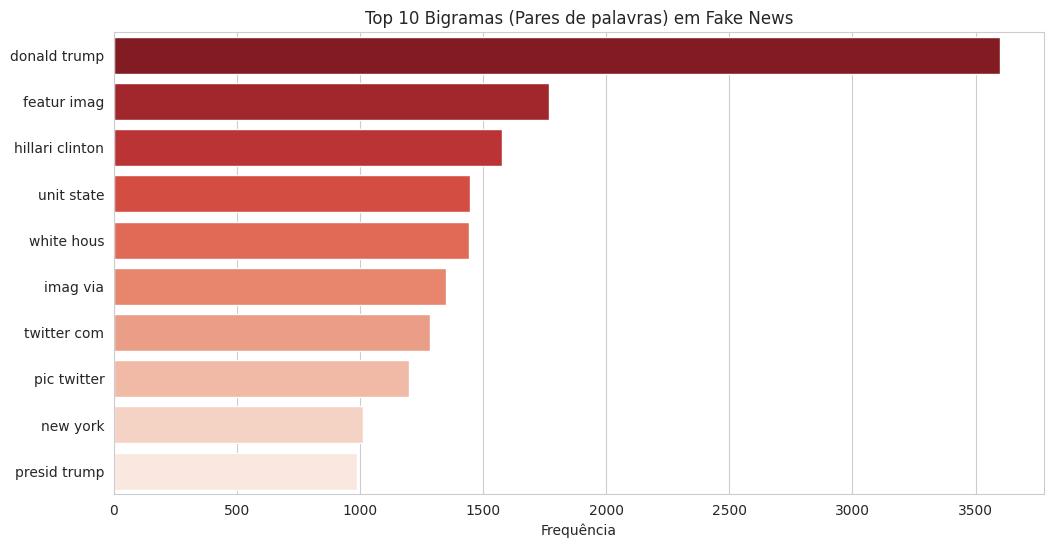

In [5]:
def get_top_bigrams(corpus, n=None):
    # Configura para contar pares de palavras (ngram_range=(2,2))
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Gerando gráfico para Fake News
plt.figure(figsize=(12, 6))
# Pegamos apenas as Fake News (target=1) e uma amostra para ser rápido
top_bigrams = get_top_bigrams(df[df['target']==1]['conteudo_limpo'].head(5000), n=10)
x, y = map(list, zip(*top_bigrams))
sns.barplot(x=y, y=x, palette='Reds_r')
plt.title('Top 10 Bigramas (Pares de palavras) em Fake News')
plt.xlabel('Frequência')
plt.show()

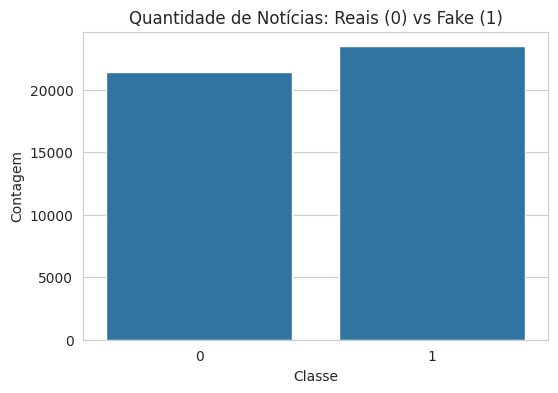

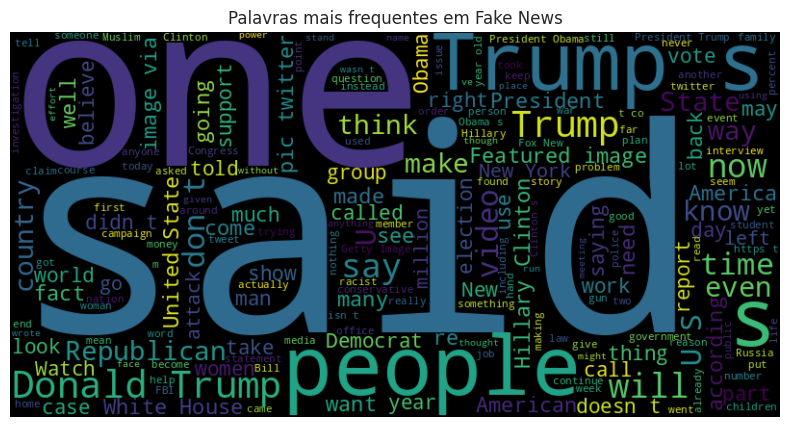

In [6]:
# Gráfico 1: Balanceamento das Classes
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Quantidade de Notícias: Reais (0) vs Fake (1)')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.show()

# Gráfico 2: Nuvem de Palavras (Fake News)
texto_fake = " ".join(df[df['target'] == 1]['conteudo'])
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(texto_fake)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes em Fake News')
plt.show()

# 6. Vetorização e Divisão dos Dados
Transformamos o texto limpo em números usando o **TF-IDF** (Term Frequency-Inverse Document Frequency).
Essa técnica dá peso maior a palavras raras e importantes, e diminui o peso de palavras que aparecem em todos os textos.
Dividimos os dados em:
* **Treino (70%):** Para ensinar o modelo.
* **Teste (30%):** Para avaliar o desempenho final.

In [7]:
# 1. Definição de X e y
X = df['conteudo_limpo']
y = df['target']

# 2. Divisão Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Vetorização TF-IDF
# Limitamos a 5000 features para manter a performance computacional
vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Dimensões do Treino:", X_train_tfidf.shape)
print("Dimensões do Teste:", X_test_tfidf.shape)

Dimensões do Treino: (31428, 5000)
Dimensões do Teste: (13470, 5000)


# 7. Construção e Treinamento do Modelo
Utilizamos o algoritmo **Multinomial Naive Bayes**.
Este modelo probabilístico é baseado no Teorema de Bayes e é amplamente utilizado em classificação de texto devido à sua eficiência e capacidade de lidar com dados de alta dimensão.

In [8]:
# Instanciando o modelo
model = MultinomialNB()

# Treinando
model.fit(X_train_tfidf, y_train)


MultinomialNB()

# 8. Avaliação de Desempenho
Avaliamos o modelo nos dados de teste (que ele nunca viu antes).
* **Acurácia:** Porcentagem total de acertos.
* **Matriz de Confusão:** Mostra onde o modelo acertou e onde errou (Falsos Positivos vs Falsos Negativos).

Acurácia Final: 0.9318

--- Relatório de Classificação ---
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      6425
           1       0.93      0.94      0.94      7045

    accuracy                           0.93     13470
   macro avg       0.93      0.93      0.93     13470
weighted avg       0.93      0.93      0.93     13470



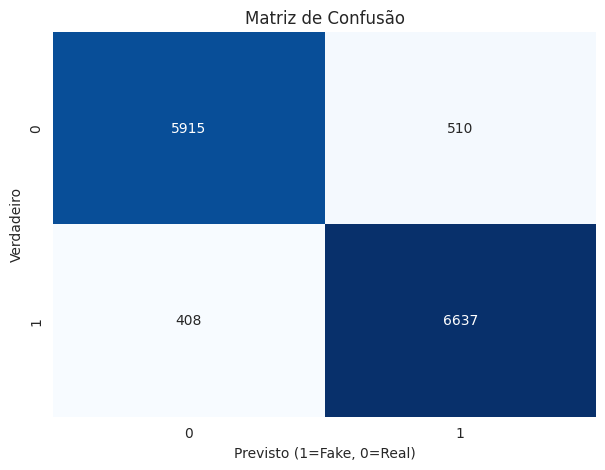

In [9]:
# Previsão
y_pred = model.predict(X_test_tfidf)

# Métricas
acc = accuracy_score(y_test, y_pred)
print(f'Acurácia Final: {acc:.4f}')
print('\n--- Relatório de Classificação ---')
print(classification_report(y_test, y_pred))

# Matriz de Confusão
plt.figure(figsize=(7, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão')
plt.xlabel('Previsto (1=Fake, 0=Real)')
plt.ylabel('Verdadeiro')
plt.show()

# 9. Curva ROC e Métrica AUC
A Curva ROC (Receiver Operating Characteristic) avalia a capacidade do modelo de distinguir entre as classes.
* A linha pontilhada azul representa um classificador aleatório (50% de chance).
* Quanto mais a curva laranja se aproxima do canto superior esquerdo, melhor o modelo.
* **AUC (Area Under Curve):** Um valor de 1.0 representa um classificador perfeito.

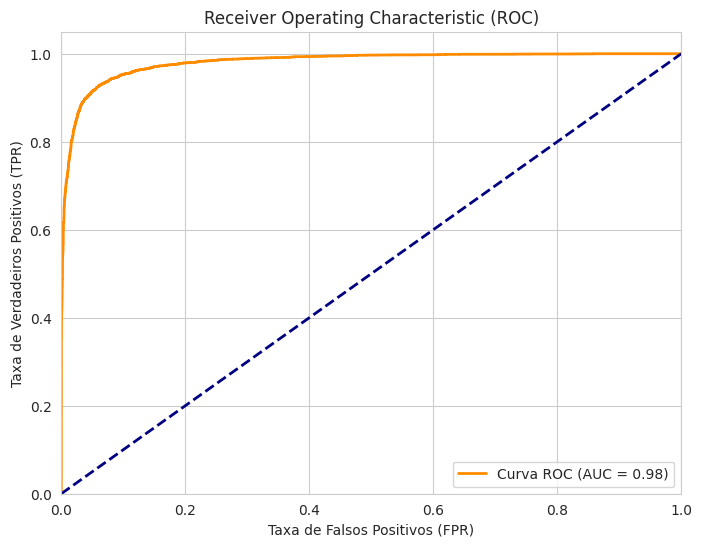

In [10]:
# Calcular probabilidades
y_prob = model.predict_proba(X_test_tfidf)[:, 1]

# Calcular pontos da curva
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotar
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 10. Interpretabilidade do Modelo
O que torna uma notícia "Fake" para o computador?
Abaixo, extraímos as palavras que o modelo Naive Bayes atribuiu maior probabilidade para cada classe.
Isso nos permite ver o vocabulário característico da desinformação (ex: termos sensacionalistas).

In [11]:
# Pegando os nomes das palavras
feature_names = vectorizer.get_feature_names_out()

# Extraindo log probabilities
log_prob_fake = model.feature_log_prob_[1]
log_prob_real = model.feature_log_prob_[0]

# Criando DataFrame de Importância
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'fake_score': log_prob_fake - log_prob_real # Diferença de probabilidade
})

print("--- Top 15 Palavras indicadoras de FAKE NEWS ---")
print(feature_importance.sort_values('fake_score', ascending=False).head(15)['feature'].values)

print("\n--- Top 15 Palavras indicadoras de NOTÍCIA REAL ---")
print(feature_importance.sort_values('fake_score', ascending=True).head(15)['feature'].values)

--- Top 15 Palavras indicadoras de FAKE NEWS ---
['pic' 'http' 'getti' 'com' 'js' 'gop' 'cop' 'boiler' 'antifa' 'hilari'
 'screenshot' 'wire' 'youtu' 'bundi' 'jeanin']

--- Top 15 Palavras indicadoras de NOTÍCIA REAL ---
['myanmar' 'rohingya' 'reuter' 'catalan' 'catalonia' 'hariri' 'mugab'
 'zuma' 'rakhin' 'puigdemont' 'ria' 'beij' 'kurdish' 'spd' 'kirkuk']


# 11. Avaliação Complementar com Validação Cruzada (K-Fold)
Nesta etapa, aproveitamos o **pré-processamento já realizado** (coluna `conteudo_limpo` e rótulo `target`) para comparar diferentes configurações de vetorização e Naive Bayes, usando **validação cruzada estratificada (K-Fold)**.

Os cenários avaliados são:
- **TF - Unigram:** Frequência simples de palavras (unigramas).
- **TF - Bigram:** Frequência de pares de palavras (bigramas).
- **TF-IDF - Unigram:** TF-IDF com unigramas.
- **TF-IDF - Bigram:** TF-IDF com bigramas.

A validação cruzada usa apenas o conjunto de **treino** (`X_train`, `y_train`), enquanto o desempenho final é medido no mesmo **conjunto de teste hold-out** (`X_test`, `y_test`) já utilizado anteriormente.

In [12]:
# Avaliação complementar com K-Fold, reaproveitando X, y, X_train, X_test, y_train, y_test

# Garantindo que X e y estão definidos a partir do texto limpo
X = df['conteudo_limpo']
y = df['target']

# Usamos apenas a parte de treino para a validação cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scenarios = {
    'TF - Unigram': Pipeline([
        ('vect', CountVectorizer(ngram_range=(1, 1))),
        ('clf', MultinomialNB())
    ]),
    'TF - Bigram': Pipeline([
        ('vect', CountVectorizer(ngram_range=(2, 2))),
        ('clf', MultinomialNB())
    ]),
    'TF-IDF - Unigram': Pipeline([
        ('vect', CountVectorizer(ngram_range=(1, 1))),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB())
    ]),
    'TF-IDF - Bigram': Pipeline([
        ('vect', CountVectorizer(ngram_range=(2, 2))),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB())
    ])
}

results = []
print('Iniciando comparação dos modelos com K-Fold...')

for name, pipe in scenarios.items():
    print(f"\n=== {name} ===")
    # A. Validação cruzada no conjunto de treino
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy')
    mean_cv = cv_scores.mean()
    print(f"Acurácia média (K-Fold): {mean_cv:.4f}")

    # B. Avaliação no mesmo teste hold-out já utilizado no notebook
    pipe.fit(X_train, y_train)
    y_pred_scenario = pipe.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_scenario)
    print(f"Acurácia no conjunto de teste: {test_acc:.4f}")

    results.append({
        'Cenário': name,
        'Validação (K-Fold)': mean_cv,
        'Teste (Hold-out)': test_acc
    })

df_results = pd.DataFrame(results)
print('\nResumo dos modelos (ordenado pelo teste hold-out):')
display(df_results.sort_values('Teste (Hold-out)', ascending=False))
best_model = scenarios['TF - Bigram']
print(classification_report(y_test, best_model.predict(X_test)))

Iniciando comparação dos modelos com K-Fold...

=== TF - Unigram ===
Acurácia média (K-Fold): 0.9511
Acurácia no conjunto de teste: 0.9517

=== TF - Bigram ===
Acurácia média (K-Fold): 0.9784
Acurácia no conjunto de teste: 0.9784

=== TF-IDF - Unigram ===
Acurácia média (K-Fold): 0.9330
Acurácia no conjunto de teste: 0.9346

=== TF-IDF - Bigram ===
Acurácia média (K-Fold): 0.9711
Acurácia no conjunto de teste: 0.9708

Resumo dos modelos (ordenado pelo teste hold-out):


,Cenário,Validação (K-Fold),Teste (Hold-out)
1,TF - Bigram,0.978363,0.978396
3,TF-IDF - Bigram,0.971141,0.970824
0,TF - Unigram,0.951063,0.951670
2,TF-IDF - Unigram,0.932990,0.934595


              precision    recall  f1-score   support

           0       0.97      0.98      0.98      6425
           1       0.99      0.97      0.98      7045

    accuracy                           0.98     13470
   macro avg       0.98      0.98      0.98     13470
weighted avg       0.98      0.98      0.98     13470



## 11.1 Matriz de Confusão do Melhor Cenário
A partir da tabela de resultados, selecionamos automaticamente o cenário com **melhor desempenho no teste hold-out** e geramos uma nova matriz de confusão para comparar com a matriz original do modelo base.

Melhor cenário segundo o teste hold-out: TF - Bigram


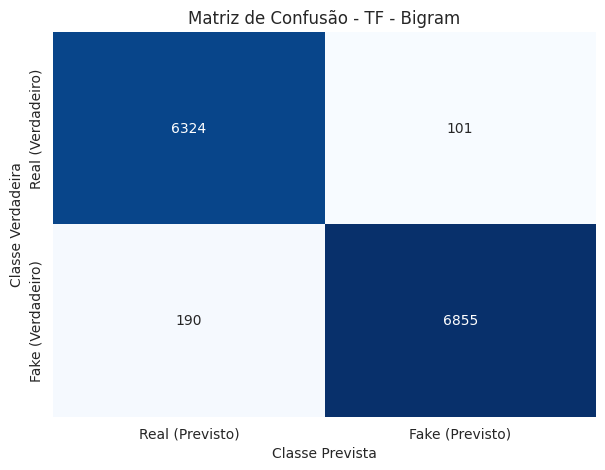

In [13]:
# Matriz de confusão do melhor cenário segundo o teste hold-out
from sklearn.metrics import confusion_matrix

best_row = df_results.sort_values('Teste (Hold-out)', ascending=False).iloc[0]
best_name = best_row['Cenário']
print(f"Melhor cenário segundo o teste hold-out: {best_name}")

best_model = scenarios[best_name]
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

cm_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Real (Previsto)', 'Fake (Previsto)'],
            yticklabels=['Real (Verdadeiro)', 'Fake (Verdadeiro)'])
plt.title(f'Matriz de Confusão - {best_name}')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.show()
